In [1]:
import numpy as np
from scipy.spatial import KDTree
INF = -1e+8

def quat2mat(q):
    """ 四元数を回転行列に変換 """
    w, x, y, z = q
    return np.array([
        [1 - 2*y*y - 2*z*z, 2*x*y + 2*w*z, 2*x*z - 2*w*y], 
        [2*x*y - 2*w*z, 1 - 2*x*x - 2*z*z, 2*y*z + 2*w*x], 
        [2*x*z + 2*w*y, 2*y*z - 2*w*x, 1 - 2*x*x - 2*y*y]
    ])

def absolute_orientation(x, y, param="mat"):
    """ xからyへの変換を求めたいとする。mは対応付け """
    c_x = np.mean(x, axis=1)[:, np.newaxis]
    c_y = np.mean(y, axis=1)[:, np.newaxis]
    X = x - c_x
    Y = y - c_y
    
    # Y = R X の R を求める
    # パラメータは回転行列
    if param == "mat" or param == "MAT" or param == "matrix":
        pass
    # パラメータは回転を表す四元数
    else:
        S = np.sum(X[:, np.newaxis, :] * Y[np.newaxis, :, :], axis=-1)
        N = np.array([
            [S[0, 0] + S[1, 1] + S[2, 2], S[1, 2] - S[2, 1],           S[2, 0] - S[0, 2],             S[0, 1] - S[1, 0]            ],
            [S[1, 2] - S[2, 1],           S[0, 0] - S[1, 1] - S[2, 2], S[0, 1] + S[1, 0],             S[2, 0] + S[0, 2]            ],
            [S[2, 0] - S[0, 2],           S[0, 1] + S[1, 0],           - S[0, 0] + S[1, 1] - S[2, 2], S[1, 2] + S[2, 1]            ],
            [S[0, 1] - S[1, 0],           S[2, 0] + S[0, 2],           S[1, 2] + S[2, 1],             - S[0, 0] - S[1, 1] + S[2, 2]],
        ])
        eigenvalue, eigenvector = np.linalg.eig(N)
        q = eigenvector[:, np.argmax(eigenvalue)]
        R = quat2mat(q).T
        t = c_y - R @ c_x
    return R, t
    

def icp(x, y, max_iter=100, param="mat"):
    """
    x, yはShape(3, N)の点群 
    y = R x + t
    """
    kdtree = KDTree(y)
    X = np.copy(x)
    Rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    N = x.shape[1]
    
    for i in range(max_iter):
        neighbor_indices = kdtree.query(X)[1]
        targets = y[neighbor_indices]
        R, t = absolute_orientation(X, targets, param=param)
        new_p = R @ X + t
        loss = np.sum(np.abs(new_p - targets)) / N
        print("iteration :", i, "Loss :", loss)
        if  loss < 1e-6:# or np.sum(np.abs(X - new_p)) < 1e-9:
            if i == 0:
                Rmat = R @ Rmat
                tvec = t + R @ tvec
            break
        X = new_p
        Rmat = R @ Rmat
        tvec = t + R @ tvec
    return X, Rmat, tvec
    

def weighted_absolute_orientation4softassign(m, x, y, num_elem):
    """ mは対応付け """
    #TODO :x, yいずれかがINFなら対応付けしない
    N = m.shape[-1]
    c_x = np.sum((x.reshape(3, N, 1) * m[np.newaxis, :, :]), axis=(1, 2)) / N
    c_y = np.sum((y.reshape(3, 1, N) * m[np.newaxis, :, :]), axis=(1, 2)) / N
    c_x, c_y = np.mean(x, axis=1), np.mean(y, axis=1)
    #print("a", c_x, c_y, np.mean(x, axis=1), np.mean(y, axis=1))
    c_x = c_x.reshape(3, 1)
    c_y = c_y.reshape(3, 1)
    X = x - c_x
    Y = y - c_y
    S = np.zeros((3, 3))
    for d1 in range(3):
        for d2 in range(3):
            for i in range(X.shape[1]):
                for j in range(Y.shape[1]):
                    S[d1, d2] += m[i, j]*X[d1, i]*Y[d2, j]
            S[d1, d2] /= N
    N = np.array([
            [S[0, 0] + S[1, 1] + S[2, 2], S[1, 2] - S[2, 1],           S[2, 0] - S[0, 2],             S[0, 1] - S[1, 0]            ],
            [S[1, 2] - S[2, 1],           S[0, 0] - S[1, 1] - S[2, 2], S[0, 1] + S[1, 0],             S[2, 0] + S[0, 2]            ],
            [S[2, 0] - S[0, 2],           S[0, 1] + S[1, 0],           - S[0, 0] + S[1, 1] - S[2, 2], S[1, 2] + S[2, 1]            ],
            [S[0, 1] - S[1, 0],           S[2, 0] + S[0, 2],           S[1, 2] + S[2, 1],             - S[0, 0] - S[1, 1] + S[2, 2]],
        ])
    D, V = np.linalg.eig(N)
    q = V[:, np.argmax(D)]
    R = quat2mat(q).T
    t = c_y - R @ c_x
    return R, t

def sinkhorn(m, max_iter=1000):
    """ 二重確率行列に変換 """
    for i in range(max_iter):
        m = m / np.sum(m, axis=0).reshape(1, -1)
        m = m / np.sum(m, axis=1).reshape(-1, 1)
    return m

def softassign(x, y, a=0.1, b=0.1, max_iter=100):
    """ 
    x, yは3次元点群, Shape(3, N) 
    a, bはパラメータ
    """
    num_elem = x.shape[1] + y.shape[1]
    Rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    for i in range(max_iter):
        beta = b + (1. - b) * i / (max_iter)
        m = np.linalg.norm(x.reshape(3, -1, 1) - y.reshape(3, 1, -1), axis=0)
        m = np.exp(
            - beta * (
                m*m - a
            )
        )
        m = sinkhorn(m)
        R, t = weighted_absolute_orientation4softassign(m, x, y, num_elem)
        x = R @ x + t
        Rmat = R @ Rmat
        tvec = t + R @ tvec
    return x, Rmat, tvec


def weighted_absolute_orientation4emicp(x, y, lam):
    sum_lam = np.sum(lam)
    c_x = np.sum(lam[np.newaxis, :] * x, axis=1) / sum_lam
    c_y = np.sum(lam[np.newaxis, :] * y, axis=1) / sum_lam
    c_x, c_y = c_x.reshape(3, 1), c_y.reshape(3, 1)
    X = x - c_x
    Y = y - c_y
    S = np.zeros((3, 3))
    for d1 in range(3):
        for d2 in range(3):
            for i in range(X.shape[1]):
                S[d1, d2] += lam[i] * X[d1, i] * Y[d2, i]
    N = np.array([
            [S[0, 0] + S[1, 1] + S[2, 2], S[1, 2] - S[2, 1],           S[2, 0] - S[0, 2],             S[0, 1] - S[1, 0]            ],
            [S[1, 2] - S[2, 1],           S[0, 0] - S[1, 1] - S[2, 2], S[0, 1] + S[1, 0],             S[2, 0] + S[0, 2]            ],
            [S[2, 0] - S[0, 2],           S[0, 1] + S[1, 0],           - S[0, 0] + S[1, 1] - S[2, 2], S[1, 2] + S[2, 1]            ],
            [S[0, 1] - S[1, 0],           S[2, 0] + S[0, 2],           S[1, 2] + S[2, 1],             - S[0, 0] - S[1, 1] + S[2, 2]],
        ])
    D, V = np.linalg.eig(N)
    q = V[:, np.argmax(D)]
    R = quat2mat(q).T
    t = c_y - R @ c_x
    return R, t

def emicp(x, y, d_0=0.1, max_iter=10):
    Rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    R = np.eye(3)
    t = np.zeros((3, 1))
    sigma_p = 10
    # 事後確率の算出
    for i in range(max_iter):
        d_ij = np.linalg.norm(x[:, :, np.newaxis] - y[:, np.newaxis, :], axis=0)
        d_ij = d_ij * d_ij
        # 事後確率
        a_ij = np.exp(d_ij)
        C_i = np.exp(- d_0 * d_0 / sigma_p) + np.sum(np.exp(- d_ij*d_ij / sigma_p), axis=1)
        a_ij = a_ij / C_i[:, np.newaxis]
        a_sqrt = np.sqrt(a_ij)
        lam = np.sum(a_sqrt, axis=1)
        z = np.sum(a_sqrt[np.newaxis, :, :] * y[:, np.newaxis, :], axis=-1) / lam[np.newaxis, :]
        R, t = weighted_absolute_orientation4emicp(x, z, lam)
        x = R @ x + t
        Rmat = R @ Rmat
        tvec = t + R @ tvec
        sigma_p *= 0.5
    return x, Rmat, tvec

ModuleNotFoundError: No module named 'scipy'

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from math import sin, cos

[[ 1.         0.         0.       ]
 [ 0.         0.8660254 -0.5      ]
 [ 0.         0.5        0.8660254]] [[0.37436827]
 [2.72473648]
 [1.70045872]]
sf [[ 1.00000000e+00 -1.06617189e-09  5.21438867e-12]
 [ 9.25939135e-10  8.66025404e-01 -5.00000000e-01]
 [ 5.28570151e-10  5.00000000e-01  8.66025404e-01]] [[0.37436827 2.72473648 1.70045872]]
em [[ 9.99999999e-01 -5.85095959e-09  4.60487603e-05]
 [ 2.30276110e-05  8.66048427e-01 -4.99960120e-01]
 [-3.98775312e-05  4.99960120e-01  8.66048426e-01]] [[0.37433565 2.72853689 1.69381098]]


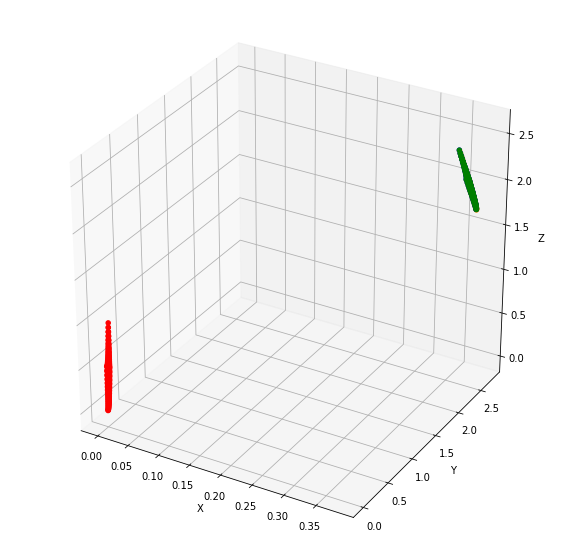

In [22]:
Y, X = np.mgrid[0:100:5, 0:100:5]
Z = Y ** 2 + X ** 2
X = np.vstack([Y.reshape(-1), X.reshape(-1), Z.reshape(-1)])
theta = np.pi / 6
max_v = np.max(X)
X = X / max_v
R = np.random.randn(3, 3)#np.array([
    #    [1, 0, 0],
    #    [0, np.cos(theta), -np.sin(theta)],
    #    [0, np.sin(theta), np.cos(theta)]
    #])#np.random.randn(3, 3)"""
R = np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]])
"""R = np.array([
        [cos(50), -sin(50), 0],
        [sin(50), cos(50), 0],
        [0, 0, 1]
    ])#"""
t = np.array([5.0, 20.0, 10.0]).reshape(3, 1) / max_v
U, D, V = np.linalg.svd(R)
R = U @ V
t = np.random.randn(3, 1)
#R = np.eye(3)
#t = np.zeros((3, 1))
Y = R @ X + t
print(R, t)
y_, R_, t_ = softassign(X, Y, max_iter=10)
#y, R, t = icp(X, Y, max_iter=100, param="quat")
y, R_em, t_em = emicp(X, Y, max_iter=10)
print("sf", R_, t_.T)
print("em", R_em, t_em.T)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

ax.scatter3D(X[0], X[1], X[2], color="red")
ax.scatter3D(Y[0], Y[1], Y[2], color="blue")
ax.scatter3D(y[0], y[1], y[2], color="orange")
ax.scatter3D(y_[0], y_[1], y_[2], color="green")
plt.show()